# A simple regulator problem

We illustrate here the coupling of direct and indirect methods in optimal control, on a simple case of Linear Quadratic Regulator in dimension 2.
More precisely, we show how the direct method can provide the relevant information to initialize the indirect method accurately, namely with the correct control structure and with an estimate of junction times as well as state and costate values at the relevant times. 
We study the following problem, for which the optimal control structure consists in a Bang arc followed by a Singular arc.

$$
\left \lbrace
\begin{array}{l}
\displaystyle \min\ \frac{1}{2}\int_0^5 (x_1^2(t) + x_2^2(t))\,\mathrm{d}t\\[1.0em]
\dot x_1(t) = x_2(t),\quad \dot x_2(t) = u(t),\quad u(t) \in [-1,1]\\[1.0em]
x(0)=(0,1)\\
\end{array}
\right .
$$



**Packages**

In [1]:
import bocop
import matplotlib.pyplot as plt
import nutopy as nt
import numpy  as np
plt.rcParams['figure.dpi'] = 180
plt.rcParams.update({"text.usetex":True})
%matplotlib inline

**Parameters**

In [2]:
t0   = 0.
tf   = 5.
x0   = np.array([0., 1.])

## Direct method

We first solve the problem with the so-called direct transcription approach, that basically consists in solving the finite-dimensional nonlinear programming problem (NLP) resulting from applying a time discretization to the original optimal control problem (OCP).
We reformulate the Lagrange cost as a Mayer cost by introducing a new state variable

$$
\left \lbrace
\begin{array}{l}
\min\ x_3(5)\\[0.5em]
\displaystyle \dot x_1(t) = x_2(t), \quad \dot x_2(t) = u(t), \quad \dot x_3(t) = \frac{1}{2} \left(x_1^2(t) + x_2^2(t)\right), \quad u(t) \in [-1,1]\\[0.5em]
x(0)=(0,1,0)\\[0.5em]
\end{array}
\right.
$$

and use the software Bocop for the numerical simulations. 
The definition of the problem consists in one C++ file for the problem functions, and one text file for all other parameters and settings.
The file `problem.cpp` defines the final cost, dynamics and boundary conditions for the OCP.

In [3]:
!pygmentize problem.cpp

#include <OCP.h>

template <typename Variable>
inline void OCP::finalCost(double initial_time, double final_time, const Variable *initial_state, const Variable *final_state, const Variable *parameters, const double *constants, Variable &final_cost)
{
    final_cost = final_state[2];
}

template <typename Variable>
inline void OCP::dynamics(double time, const Variable *state, const Variable *control, const Variable *parameters, const double *constants, Variable *state_dynamics)
{
    Variable x1 = state[0];
    Variable x2 = state[1];
    Variable u = control[0];
    state_dynamics[0] = x2;
    state_dynamics[1] = u;
    state_dynamics[2] = 0.5*(x1*x1+x2*x2);

}

template <typename Variable>
inline void OCP::boundaryConditions(double initial_time, double final_time, const Variable *initial_state, const Variable *final_state, const Variable *parameters, const double *constants, Variable *boundary_conditions)
{
    boundary_conditions[0] =  initial_state[0];
    boundary_conditions[1] =  

The file `problem.def` contains all other relevant information, such as problem dimensions, time discretization choices, bounds for the different variables and constraints, initial guess and numerical settings for the NLP solver Ipopt, etc

In [4]:
!pygmentize problem.def

# Definition file

# Dimensions
dim.state 3
dim.control 1
dim.boundaryconditions 3
dim.pathconstraints 0
dim.parameters 0
dim.constants 0

# Time interval
initial.time 0
final.time 5

# Constants

# Time discretisation
time.steps 1000
ode.discretization midpoint_implicit

# Bounds for constraints
boundarycond.0.lowerbound 0
boundarycond.0.upperbound 0
boundarycond.1.lowerbound 1
boundarycond.1.upperbound 1
boundarycond.2.lowerbound 0
boundarycond.2.upperbound 0

# Bounds for variables
control.0.lowerbound -1
control.0.upperbound 1

# Initialization for discretized problem
state.0.init 0.1
state.1.init 0.1
state.2.init 0.1
control.0.init 0.1

# Names

# Ipopt
ipoptIntOption.print_level 5
ipoptIntOption.max_iter 1000
ipoptStrOption.mu_strategy adaptive
ipoptNumOption.tol 1e-12

# Misc
ad.retape 0


We build the problem executable. This step has to be performed only once (unless the `C++` file defining the dynamics is modified).

In [5]:
problem_path = "." # using local problem definition

# Uncomment to build the problem
bocop.build(problem_path, cmake_options = '-DCMAKE_CXX_COMPILER=g++')

[EXEC] > ['cmake -DCMAKE_BUILD_TYPE=Debug -DPROBLEM_DIR=/Users/ocots/Boulot/recherche/Logiciels/dev/ct/gallery/examples/regulator -DCPP_FILE=problem.cpp  -DCMAKE_CXX_COMPILER=g++  /Users/ocots/opt/miniconda3/envs/gallery/lib/python3.7/site-packages/bocop']
>	-- The C compiler identification is Clang 14.0.4
>	-- The CXX compiler identification is AppleClang 13.0.0.13000029
>	-- Detecting C compiler ABI info
>	-- Detecting C compiler ABI info - done
>	-- Check for working C compiler: /Users/ocots/opt/miniconda3/envs/gallery/bin/x86_64-apple-darwin13.4.0-clang - skipped
>	-- Detecting C compile features
>	-- Detecting C compile features - done
>	-- Detecting CXX compiler ABI info
>	-- Detecting CXX compiler ABI info - done
>	-- Check for working CXX compiler: /usr/bin/g++ - skipped
>	-- Detecting CXX compile features
>	-- Detecting CXX compile features - done
>	-- Problem path: /Users/ocots/Boulot/recherche/Logiciels/dev/ct/gallery/examples/regulator
>	-- Using CPPAD found at /Users/ocots

0

We finally solve the problem by launching the optimization.

In [6]:
bocop.run(problem_path)

interactive(children=(IntSlider(value=19, continuous_update=False, description='iteration', max=19), Output())…

Done


## Solution analysis

In addition to the state and control from the optimal trajectory, we can
plot the Lagrange multipliers associated to the constraints for the
discretized dynamics, that correspond to the costate variables from
Pontrjagin Maximum Principle. Note that for the case of basic initial
conditions $x_i(0)=x_i^0$, the multipliers for these constraints will
also match the costate variables at the initial time for the corresponding state variables.
For this problem the third costate is constant and
equal to $-1$, which is normal since the third state corresponds to
the integral cost to be minimized. The solution exhibits a bang-singular
structure, as can be clearly seen from the followin figure on the control variable in purple. The
oscillations of the control over the singular arc are often encountered
when using discrete transcription, however the averaged control usually
corresponds to the correct singular control, meaning that the state
dynamics should be close to the optimal trajectory.

In [7]:
# BOCOP solution
bocop_solution = bocop.readSolution(problem_path + "/problem.sol")
bocop_p0 = bocop_solution.costate[0:bocop_solution.dim_state,0]

Loading solution:  ./problem.sol


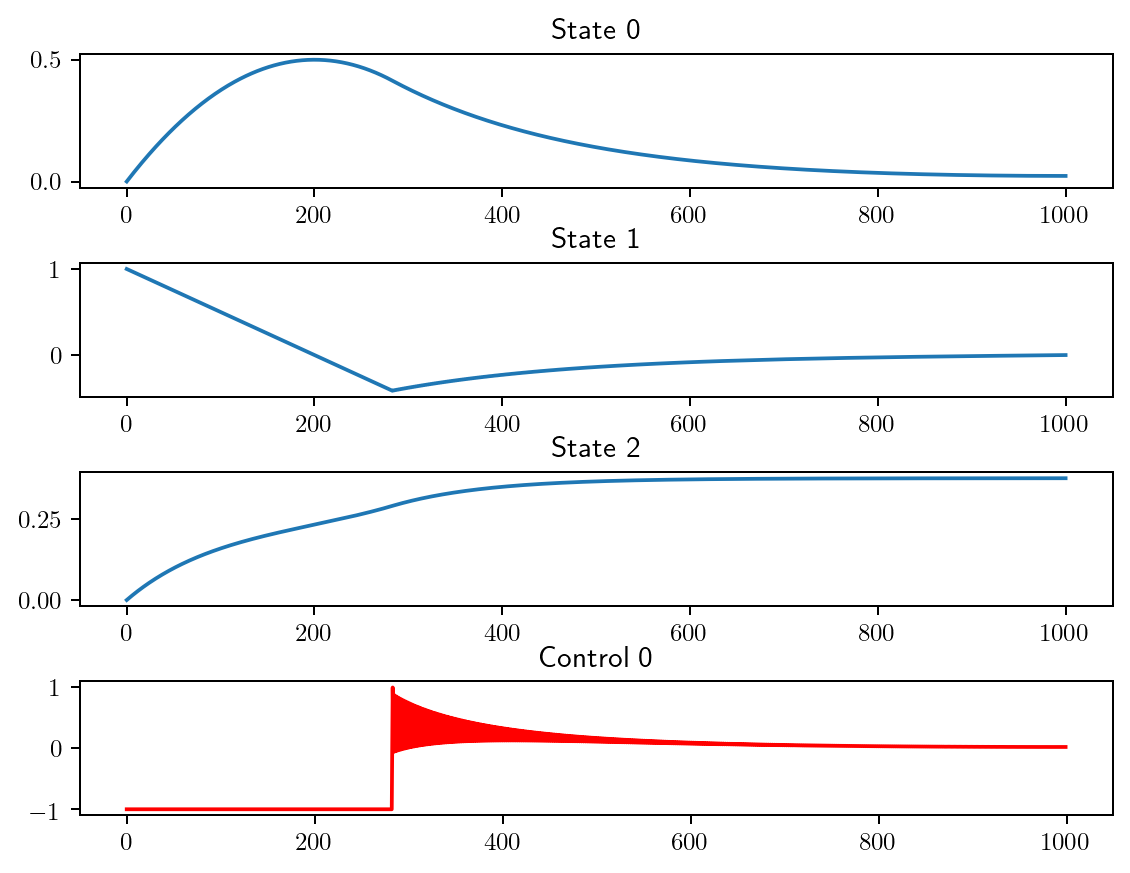

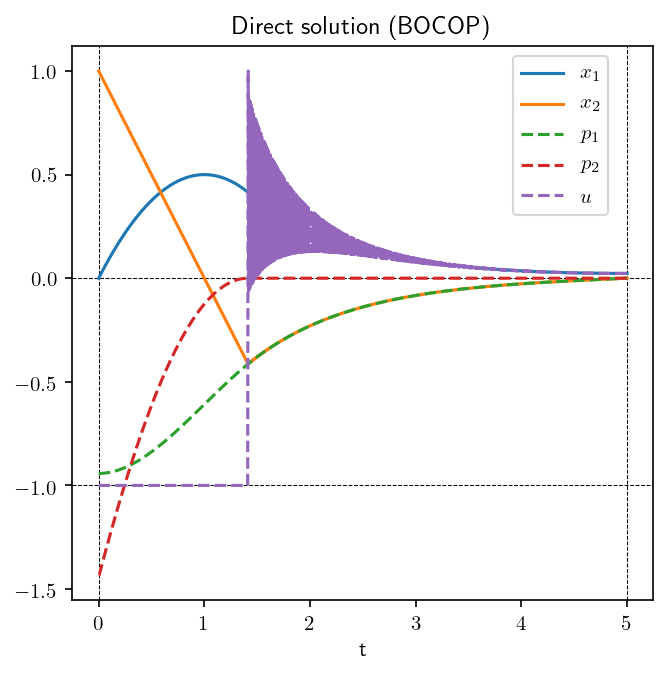

In [8]:
# Plot BOCOP solution

tspan = bocop_solution.time_steps

x1    = bocop_solution.state[0]
x2    = bocop_solution.state[1]
p10   = bocop_p0[0]; p1 = np.concatenate(([p10], bocop_solution.costate[0]))
p20   = bocop_p0[1]; p2 = np.concatenate(([p20], bocop_solution.costate[1]))
u     = bocop_solution.control[0]; u = np.concatenate((u, [u[-1]]));
#s     = H1(tspan, [x1, x2], [p1, p2])

fig = plt.figure(dpi=150);
fig.set_figwidth(5);

ax  = plt.subplot(1,1,1); 
ax.axvline(t0, color='k', linestyle='--', linewidth=0.5);
ax.axvline(tf, color='k', linestyle='--', linewidth=0.5);
ax.axhline( 0, color='k', linestyle='--', linewidth=0.5);
ax.axhline(-1, color='k', linestyle='--', linewidth=0.5);

l1, = plt.plot(tspan, x1)
l2, = plt.plot(tspan, x2)
l3, = plt.plot(tspan, p1, linestyle='--')
l4, = plt.plot(tspan, p2, linestyle='--')
l5, = plt.plot(tspan, u, linestyle='--')

ax.legend([l1, l2, l3, l4, l5], ['$x_1$', '$x_2$', '$p_1$', '$p_2$', '$u$'], loc='upper right', bbox_to_anchor=(0.94, 1))
ax.set_xlabel('t');
ax.set_title('Direct solution (BOCOP)');

#plt.savefig("regulator_direct.eps", dpi=150)

In [9]:
# Verbose
print("Bocop returns status {} with objective {:2.4g} and constraint violation {:2.4g}".format(bocop_solution.status,
                                                                                               bocop_solution.objective,
                                                                                               bocop_solution.constraints))
print("Costate at first time stage (t0+h/2): ", bocop_p0)
print("Multipliers for initial conditions: ", bocop_solution.boundarycond_multipliers[0:bocop_solution.dim_state])

Bocop returns status 0 with objective 0.377 and constraint violation 1.221e-12
Costate at first time stage (t0+h/2):  [-0.94215546 -1.43220296 -1.        ]
Multipliers for initial conditions:  [-0.94216793 -1.44190126 -1.        ]


## Indirect method
Using the information gathered on the solution from the direct method, we can now solve the problem accurately with an indirect method, with the knowledge of both the optimal control structure and an estimate of the junction time and state-costate values at these times. We use the package `nutopy` for the indirect shooting method. Applying Pontrjagin maximum principle, one has to consider the following Hamiltonian (in normal form since there are no terminal constraints):

$$ H(x_1,x_2,p_1,p_2,u) = -(1/2)(x_1^2+x_2^2) + p_1 x_2 + p_2 u. $$

One checks that the control is either bang (equal to $\pm 1$) or singular. Singular arcs are actually of order one, given by the condition $p_2=0$ (singular arcs actually leave on the codimension two submanifold $\{p_2=x_2-p_1=0\}$ of the cotangent bundle $T\mathbf{R^2} \simeq \mathbf{R}^2\times\mathbf{R}^2$, and the singular control (in feedback form) is $u=x_1$. So we have a competition between three Hamiltonian flows, respectively associate with

$$ H_{\pm}(x,p) := H(x,p,\pm 1),\quad H_s(x,p) := H(x,p,x_1). $$

We define these three Hamiltonians and the corresponding flows in order to set up our shooting algorithm. (For this particular example, in view of the BOCOP run, we restrict to just $-1$ bang arcs.)

In [10]:
# ------------
# Running cost
def df0fun(t, x, dx, u, du):
    df0 = x[0]*dx[0] + x[1]*dx[1]
    return df0

def d2f0fun(t, x, dx, d2x, u, du, d2u):
    d2f0 = dx[0]*d2x[0] + dx[1]*d2x[1]
    return d2f0

@nt.tools.tensorize(df0fun, d2f0fun, tvars=(2, 3))
def f0fun(t, x, u):
    f0 = 0.5 * (x[0]**2 + x[1]**2)
    return f0

# --------
# Dynamics
def dffun(t, x, dx, u, du):
    df = np.zeros(2)
    df[0] = dx[1]
    df[1] = du
    return df

def d2ffun(t, x, dx, d2x, u, du, d2u):
    d2f = np.zeros(2)
    return d2f

@nt.tools.tensorize(dffun, d2ffun, tvars=(2, 3))
def ffun(t, x, u):
    f = np.zeros(2)
    f[0] = x[1]
    f[1] = u
    return f

# ---
# OCP
o = nt.ocp.OCP(f0fun, ffun)

In [11]:
# ------------
# Bang control
def dubang(t, x, dx, p, dp):
    return 0.

def d2ubang(t, x, dx, d2x, p, dp, d2p):
    return 0.

@nt.tools.vectorize(vvars=(1, 2, 3))
@nt.tools.tensorize(dubang, d2ubang, tvars=(2, 3))
def ubang(t, x, p):
    u = -1.
    return u

# ----------------
# Singular control
def dusing(t, x, dx, p, dp):
    return dx[0]

def d2using(t, x, dx, d2x, p, dp, d2p):
    return d2x[0]

@nt.tools.vectorize(vvars=(1, 2, 3))
@nt.tools.tensorize(dusing, d2using, tvars=(2, 3))
def using(t, x, p):
    return x[0]

# ----------------------
# Hamiltonians and Flows
hbang = nt.ocp.Hamiltonian.fromOCP(o, ubang)
hsing = nt.ocp.Hamiltonian.fromOCP(o, using)

fbang = nt.ocp.Flow(hbang)
fsing = nt.ocp.Flow(hsing)

Assuming a bang-singular structure, it is then easy to define a shooting function whose unknowns are the value $p_0$ of the costate at initial time, $(x_1,p_1)$ the state and costate values at the junction point between the ($-1$) bang arc and the singular one, and the time $t_1$ where this junction occurs. A standard solver, properly initialised thanks to the previous solution provided by BOCOP, is eventually called to solve the problem. As is clear from the obtained numerical results, a very precise solution is computed. 

In [12]:
# -----------------------------------
# Derivative of the shooting function
def dshoot(z, dz):
    
    # parse unknown z = (p0,t1,x1,p1)
    p0, dp0       = z[0:2], dz[0:2]
    t1, dt1       = z[2], dz[2]
    x1_in, dx1_in = z[3:5], dz[3:5]
    p1_in, dp1_in = z[5:7], dz[5:7]
    s, ds         = np.ones(7), np.ones(7)
    
    # first bang arc
    (x1, dx1), (p1, dp1) = fbang(t0, x0, (p0,dp0), (t1,dt1))
    s[3:5], ds[3:5]  = x1 - x1_in, dx1 - dx1_in
    s[5:7], ds[5:7]  = p1 - p1_in, dp1 - dp1_in
    
    # singular arc
    (xf, dxf), (pf, dpf) = fsing((t1,dt1), (x1_in,dx1_in), (p1_in,dp1_in), tf)
    s[0], ds[0] = p1[1], dp1[1]
    s[1], ds[1] = x1[1] - p1[0], dx1[1] - dp1[0]
    s[2], ds[2] = pf[0], dpf[0]
    
    return s, ds

# -----------------
# Shooting function
@nt.tools.tensorize(dshoot, full=True)
def shoot(z):
    
    # parse unknown z = (p0,t1,x1,p1)
    p0 = z[0:2]
    t1 = z[2]
    x1_in = z[3:5]
    p1_in = z[5:7]
    s = np.ones(7)
    
    # first bang arc
    x1, p1 = fbang(t0, x0, p0, t1)
    s[3:5] = x1 - x1_in # matching conditions 
    s[5:7] = p1 - p1_in # matching conditions
    
    # singular arc
    xf, pf = fsing(t1, x1_in, p1_in, tf)
    s[0] = p1[1]         # p2(t1)
    s[1] = x1[1] - p1[0] # x2(t1)-p1(t1)
    s[2] = pf[0]         # p1(tf)

    return s
    

In [13]:
# ------------------------------
# Find zero of shooting function

z0     = np.array([bocop_p0[0], bocop_p0[1], 1.4, 0.3, -0.4, -0.6, 0])
nleopt = nt.nle.Options(SolverMethod='hybrj', TolX=1e-8)
sol    = nt.nle.solve(shoot, z0, df=shoot, options=nleopt)
z_sol  = sol.x

print("Norm of the shooting function: ", np.linalg.norm(shoot(z_sol)))


     Calls  |f(x)|                 |x|
 
         1  5.506349975841379e+00  2.347096552484115e+00
         2  9.515986448835065e-02  2.351376407081736e+00
         3  2.763674924589690e-02  2.337764011312881e+00
         4  1.483945829887381e-04  2.340877879705303e+00
         5  3.946895003995284e-06  2.340866282995954e+00
         6  1.048435990418442e-07  2.340865847032248e+00
         7  1.237808124694713e-10  2.340865858484743e+00
         8  5.400314267047623e-16  2.340865858471237e+00

 Results of the nle solver method:

 xsol    =  [-9.42173346e-01 -1.44191018e+00  1.41376409e+00  4.14399640e-01
 -4.13764088e-01 -4.13764088e-01 -1.26506733e-28]
 f(xsol) =  [-2.22044605e-16  3.33066907e-16  1.31838984e-16  5.55111512e-17
  1.11022302e-16 -2.22044605e-16 -2.22044605e-16]
 nfev    =  8
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

Norm of the shooting function:  5.400314267047623e-16


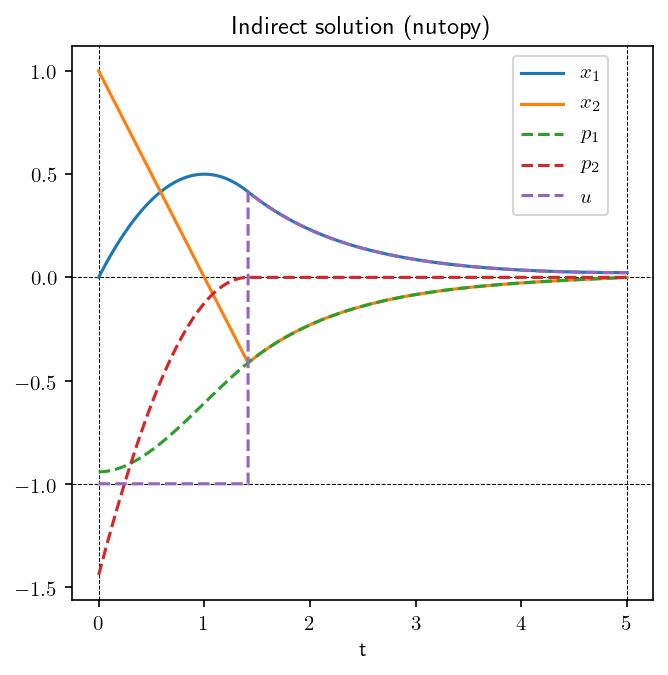

In [14]:
# -------------
# Plot solution

p0_sol = z_sol[0:2]
t1_sol = z_sol[2]
x1_sol = z_sol[3:5]
p1_sol = z_sol[5:7]

N = 100

tspan1 = list(np.linspace(t0, t1_sol, N+1))
x1, p1 = fbang(t0, x0, p0_sol, tspan1)
u1     = ubang(tspan1, x1, p1)
x1     = np.array(x1)
p1     = np.array(p1)

tspan2 = list(np.linspace(t1_sol, tf, N+1))
x2, p2 = fsing(t1_sol, x1_sol, p1_sol, tspan2)
u2     = using(tspan2, x2, p2)
x2     = np.array(x2)
p2     = np.array(p2)

fig = plt.figure(dpi=150);
fig.set_figwidth(5);

ax  = plt.subplot(1,1,1); 
ax.axvline(t0, color='k', linestyle='--', linewidth=0.5);
ax.axvline(tf, color='k', linestyle='--', linewidth=0.5);
ax.axhline( 0, color='k', linestyle='--', linewidth=0.5);
ax.axhline(-1, color='k', linestyle='--', linewidth=0.5);

l1, = plt.plot(np.concatenate((tspan1, tspan2)), np.concatenate((x1[:, 0], x2[:, 0])))
l2, = plt.plot(np.concatenate((tspan1, tspan2)), np.concatenate((x1[:, 1], x2[:, 1])))
l3, = plt.plot(np.concatenate((tspan1, tspan2)), np.concatenate((p1[:, 0], p2[:, 0])), linestyle='--')
l4, = plt.plot(np.concatenate((tspan1, tspan2)), np.concatenate((p1[:, 1], p2[:, 1])), linestyle='--')
l5, = plt.plot(np.concatenate((tspan1, tspan2)), np.concatenate((u1, u2)), linestyle='--')

ax.legend([l1, l2, l3, l4, l5], ['$x_1$', '$x_2$', '$p_1$', '$p_2$', '$u$'], loc='upper right', bbox_to_anchor=(0.94, 1))
ax.set_xlabel('t');
ax.set_title('Indirect solution (nutopy)');

#plt.savefig("regulator_indirect.eps", dpi=150)

[Thumbnail](regulator.png)